# Running a multilevel sweep parameter study with PhysiCOOL


In [1]:
%matplotlib notebook
from typing import List
from pathlib import Path

import numpy as np

from physicool.config import ConfigFileParser
from physicool.optimization import PhysiCellBlackBox
from physicool.processing import Cells

def params_updater(new_values: List[float]) -> None:
    """
    Updates the cell speed and the migration bias.

    Parameters
    ----------
    new_values: list[float]
        The parameter values for (1) the cell speed,
        and (2) the migration bias.
    """
    cell_definition_name = "cancer"

    # Read the data from the file
    xml_parser = ConfigFileParser()
    cell_data = xml_parser.read_cell_data(cell_definition_name)

    # Update values
    cell_data.motility.speed = new_values[0]
    cell_data.motility.bias = new_values[1]
    xml_parser.update_params(cell_definition_name, cell_data)

def output_processor(output_path: Path) -> np.ndarray:
    cells = Cells(time=12, storage_path=output_path)
    coordinates = cells.get_cell_positions()
    
    return np.array([coord[1] for coord in coordinates])

my_model = PhysiCellBlackBox(params_updater, output_processor)

## Generating data (optional)
We do not have any data, so we need to generate some datasets. This step could be replaced by loading some target data from a file, though. However, it is important to make sure that the data fits the model output format!

In [2]:
params = [3.0, 0.8]
target_data = my_model.run(params)
print(target_data)

[ 333.50383448  493.03872564  272.94963884  493.03690109  243.35114133
  493.02506047  493.0323338   493.02366773  493.03527246  493.02598231
  493.04125907  493.0260029   493.03114031  493.02720142  233.33181368
  493.03178443  286.72838107  493.04064613  493.0234546   192.90210706
  493.02164223 -493.02793469 -493.03492643 -493.03550998 -493.02245586
 -493.0261947  -493.02486203 -493.02171531 -493.02494999 -493.04336699
 -493.04430587 -493.02138178 -493.04036465 -315.35366102 -335.40065461
 -493.02333993 -217.20399761 -493.04144967 -418.34807658 -493.03870391
 -493.03431556 -450.99945062  493.03818506  210.79825174  493.02728695
  493.02193606  334.05729561  493.03099291  493.03682201  356.87941708
  493.02263009  432.97819487  493.02293516  493.02110114  223.94313677
  493.03024162  493.04251782  493.04094887  493.02624211  270.49041807
  493.04124924  493.02643653  493.0305646   493.02408039  493.03242703
  493.03833068  493.04330456  493.03452256  493.03043527  493.02405781
  493.

## Running the multilevel sweep pipeline

### The calibration model
First of all, **we need to define our "black-box"**. PhysiCOOL can help us do this, using `OptModel`.

`OptModel` will create a black-box function that **takes in a parameters dictionary**, **runs a PhysiCell simulation** with the updated parameter values and then **computes the metric you select** when initializing the model

You can **call this function independently**, and it will output an array with the values for the metric you choose. Here, we will be using it **inside our multilevel parameter sweep**.

<IPython.core.display.Javascript object>


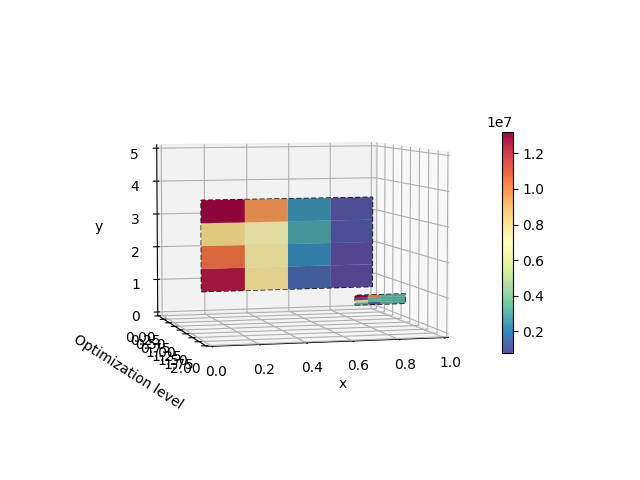

Optimal value found: 0.7400000000000001; 0.8250000000000001


In [3]:
from physicool.optimization import MultiSweep

# Create our multisweep pipeline
number_of_levels = 2
points_per_direction = 5
percent_per_direction = 0.7

ms = MultiSweep(my_model, target_data, n_levels=number_of_levels, 
                npdir=points_per_direction, ppdir=percent_per_direction)

# Select initial value for the parameter sweep
ms.set_fit_value(2.0, 0.6)
ms.set_param_bounds((0, None), (0, 1))

# Run multisweep and get optimal parameters
x, y = ms.run_sweep()

print(f'Optimal value found: {x}; {y}')